# Finding the temporal autocorrelation order and evidence of slope
This notebook fits an ARIMA model for WESE data looking for evidence of change

In [69]:
# Load libraries
library(forecast); library(ggplot2);library(plyr); library(dplyr); library(fmsb); library(stats); library(lmtest); library(modelr)

In [2]:
# Load the data
master<-read.csv("~/Workspace/Anthropocene/data/MASTER_SIE_MOD.csv")

In [3]:
#calculating the annual percentage change for WESE
master_gr <- master %>% mutate(growth_wese=log(WESE/lag(WESE)))%>% mutate(growth_wese_1=log(WESE_1/lag(WESE_1)))


In [72]:
master_gr<-subset(master_gr,year>2002 & year<2019)

In [71]:
head(master_gr)

,year,intP_RSP,mnChl_aw_RSP,mnOW_RSP,nmSST_aw_RSP,intP_MCM,mnChl_aw_MCM,mnOW_MCM,nmSST_aw_MCM,mnAirTemp,⋯,nmSST_aw_RSP_2,mnWind_2,GyreSPD_2,GyreSPD_lag4_2,GyreSPD_lag5_2,Salinity_2,intP_RSP_2,Prop._134_2,TOTALTonnes.100_2,mnSIE_2
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,2003,0.658810,1.278130,190735,-1.047010,0.1797500,0.2424260,2701.45,-1.177640,-4.625,⋯,1.0962299,73.96,49.00,38.44,39.69,1213.547,0.4340306,3025,201.0923,8.173881
5,2004,0.659537,1.201000,268734,-0.546599,0.0595893,0.0920093,1115.63,-1.394120,-5.000,⋯,0.2987705,70.56,51.84,40.96,38.44,1213.477,0.4349891,1225,426.2491,7.612081
6,2005,0.617897,1.116710,236044,-0.551816,0.2451990,0.5341190,3630.16,-1.099050,-5.250,⋯,0.3045009,77.44,60.84,43.56,40.96,1210.692,0.3817967,1444,1125.8508,8.020224
7,2006,0.673591,1.344420,218199,-0.970962,0.3927390,0.5908280,4718.94,-0.954533,-6.000,⋯,0.9427672,77.44,29.16,19.36,43.56,1211.040,0.4537248,2025,729.6968,7.496644
8,2007,0.543325,1.170400,188097,-1.006890,0.3533950,0.6396110,3903.53,-1.064650,-6.800,⋯,1.0138275,88.36,24.01,49.00,19.36,NA,0.2952021,1764,814.4232,9.771876
9,2008,0.525248,0.962226,241795,-0.846050,0.2566900,0.5890600,1968.25,-1.173800,-5.025,⋯,0.7158006,67.24,54.76,51.84,49.00,1212.432,0.2758855,1681,500.7257,10.029889


In [6]:
master_gr$mnOW_MCM6<- master_gr$mnOW_MCM/10^3

In [7]:
#lag 5 years SIE
master_gr <- master_gr %>% mutate(SIE_lag5 = lag(av_SIE,5))
master_gr[5,"SIE_lag5"]<-2.703
master_gr[4,"SIE_lag5"]<-3.123
master_gr[3,"SIE_lag5"]<-2.731
master_gr[2,"SIE_lag5"]<-2.767
master_gr[1,"SIE_lag5"]<-2.60

#lag 4 years SIE
master_gr <- master_gr %>% mutate(SIE_lag4 = lag(av_SIE,4))
master_gr[4,"SIE_lag4"]<-2.703
master_gr[3,"SIE_lag4"]<-3.123
master_gr[2,"SIE_lag4"]<-2.731
master_gr[1,"SIE_lag4"]<-2.767


#lag 4 years Gyre
master_gr <- master_gr %>% mutate(GyreSPD_lag4 = lag(GyreSPD,4))
master_gr[4,"GyreSPD_lag4"]<-6.2
master_gr[3,"GyreSPD_lag4"]<-6.3
master_gr[2,"GyreSPD_lag4"]<-5.7
master_gr[1,"GyreSPD_lag4"]<-5.8

#lag 5 years Gyre
master_gr <- master_gr %>% mutate(GyreSPD_lag5 = lag(GyreSPD,5))
master_gr[5,"GyreSPD_lag5"]<-6.2
master_gr[4,"GyreSPD_lag5"]<-6.3
master_gr[3,"GyreSPD_lag5"]<-5.7
master_gr[2,"GyreSPD_lag5"]<-5.8
master_gr[1,"GyreSPD_lag5"]<-5.0

#lag 5 years Air Temp
master_gr <- master_gr %>% mutate(mnAirTemp_lag5 = lag(mnAirTemp,5))
master_gr[5,"mnAirTemp_lag5"]<--5.6
master_gr[4,"mnAirTemp_lag5"]<--4.5
master_gr[3,"mnAirTemp_lag5"]<--5.2
master_gr[2,"mnAirTemp_lag5"]<--7.7
master_gr[1,"mnAirTemp_lag5"]<--4.2

#lag 4 years Air Temp
master_gr <- master_gr %>% mutate(mnAirTemp_lag4 = lag(mnAirTemp,4))
master_gr[5,"mnAirTemp_lag4"]<--5.6
master_gr[4,"mnAirTemp_lag4"]<--4.5
master_gr[3,"mnAirTemp_lag4"]<--5.2
master_gr[2,"mnAirTemp_lag4"]<--7.7


#lag 4 years FIE
master_gr <- master_gr %>% mutate(FIE_lag6 = lag(FIE,6))


# VARIABLES WITHOUT DATA FOR THE LAGGED YEARS (before 1998)

master_gr <- master_gr %>% mutate(mnWind_lag = lag(mnWind,5))
master_gr <- master_gr %>% mutate(Salinity_lag = lag(Salinity,5))
master_gr <- master_gr %>% mutate(mnSST_lag = lag(nmSST_aw_RSP,5))
master_gr <- master_gr %>% mutate(Prop134_lag = lag(Prop._134,5))
master_gr <- master_gr %>% mutate(FIE_lag4 = lag(FIE,4))


In [8]:
# Quadratic variables
master_gr$FIE_2<- master_gr$FIE^2
master_gr$FIE_lag4_2<- master_gr$FIE_lag4^2
master_gr$SIE_lag4_2<- master_gr$SIE_lag4^2
master_gr$SIE_2<- master_gr$mnSIE^2
master_gr$mnAirTemp_2<- master_gr$mnAirTemp^2
master_gr$SIE_lag5_2<- master_gr$SIE_lag5^2
master_gr$mnOW_RSP6<- master_gr$mnOW_RSP/10^3
master_gr$mnOW_MCM6<- master_gr$mnOW_MCM/10^3
master_gr$mnOW_RSP6_2<-master_gr$mnOW_RSP6^2
master_gr$mnOW_MCM6_2<-master_gr$mnOW_MCM6^2
master_gr$mnChl_aw_RSP_2<-master_gr$mnChl_aw_RSP^2
master_gr$nmSST_aw_RSP_2<-master_gr$nmSST_aw_RSP^2
master_gr$mnWind_2<-master_gr$mnWind^2
master_gr$GyreSPD_2<-master_gr$GyreSPD^2
master_gr$GyreSPD_lag4_2<-master_gr$GyreSPD_lag4^2
master_gr$GyreSPD_lag5_2<-master_gr$GyreSPD_lag5^2
master_gr$Salinity_2<-master_gr$Salinity^2
master_gr$intP_RSP_2<-master_gr$intP_RSP^2
master_gr$Prop._134_2<-master_gr$Prop._134^2
master_gr$TOTALTonnes.100_2<-master_gr$TOTALTonnes.100^2
master_gr$mnSIE_2<- master_gr$mnSIE^2
master_gr$mnAirTemp_2<- master_gr$mnAirTemp^2

In [9]:
head(master_gr)


,year,intP_RSP,mnChl_aw_RSP,mnOW_RSP,nmSST_aw_RSP,intP_MCM,mnChl_aw_MCM,mnOW_MCM,nmSST_aw_MCM,mnAirTemp,⋯,nmSST_aw_RSP_2,mnWind_2,GyreSPD_2,GyreSPD_lag4_2,GyreSPD_lag5_2,Salinity_2,intP_RSP_2,Prop._134_2,TOTALTonnes.100_2,mnSIE_2
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2000,0.5873935,1.098477,200943,-0.924639,0.3527637,0.6385173,2959.68,-1.109230,-4.450,⋯,0.8549573,60.84,40.96,33.64,25.00,1210.344,0.34503108,1296,44.81499,8.898289
2,2001,0.7697252,1.460241,250135,-0.645706,1.0612940,3.1205994,4366.66,-0.911519,-6.175,⋯,0.4169362,73.96,43.56,32.49,33.64,1213.477,0.59247683,144,32.31809,8.785296
3,2002,0.2079730,0.311760,100918,-1.117230,0.1219010,0.1905980,1748.01,-1.109550,-6.050,⋯,1.2482029,77.44,19.36,39.69,32.49,1213.826,0.04325277,196,151.50163,7.722841
4,2003,0.6588100,1.278130,190735,-1.047010,0.1797500,0.2424260,2701.45,-1.177640,-4.625,⋯,1.0962299,73.96,49.00,38.44,39.69,1213.547,0.43403062,3025,201.09225,8.173881
5,2004,0.6595370,1.201000,268734,-0.546599,0.0595893,0.0920093,1115.63,-1.394120,-5.000,⋯,0.2987705,70.56,51.84,40.96,38.44,1213.477,0.43498905,1225,426.24906,7.612081
6,2005,0.6178970,1.116710,236044,-0.551816,0.2451990,0.5341190,3630.16,-1.099050,-5.250,⋯,0.3045009,77.44,60.84,43.56,40.96,1210.692,0.38179670,1444,1125.85078,8.020224


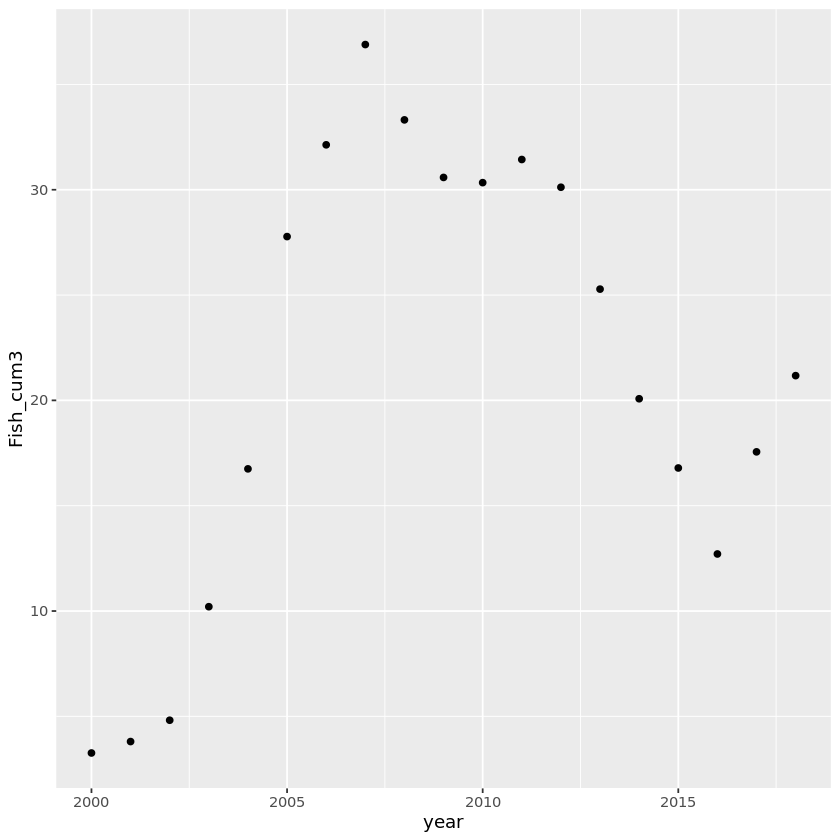

In [10]:
ggplot(master_gr, aes(x=year, y= Fish_cum3))+geom_point()

# Arima model with growth_wese

In [11]:
#checking best model
mdl1<-Arima(master_gr$growth_wese,order=c(1,0,0),include.mean=F,include.drift=T)
summary(mdl1)

Series: master_gr$growth_wese 
ARIMA(1,0,0) with drift 

Coefficients:
          ar1  drift
      -0.3409  9e-04
s.e.   0.2325  4e-03

sigma^2 estimated as 0.07512:  log likelihood=-1.37
AIC=8.74   AICc=10.34   BIC=11.58

Training set error measures:
                      ME      RMSE       MAE      MPE     MAPE     MASE
Training set -0.00897238 0.2592505 0.1923701 108.2647 112.9072 0.619005
                    ACF1
Training set -0.07481332



	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with drift
Q* = 1.7717, df = 3, p-value = 0.6211

Model df: 2.   Total lags used: 5



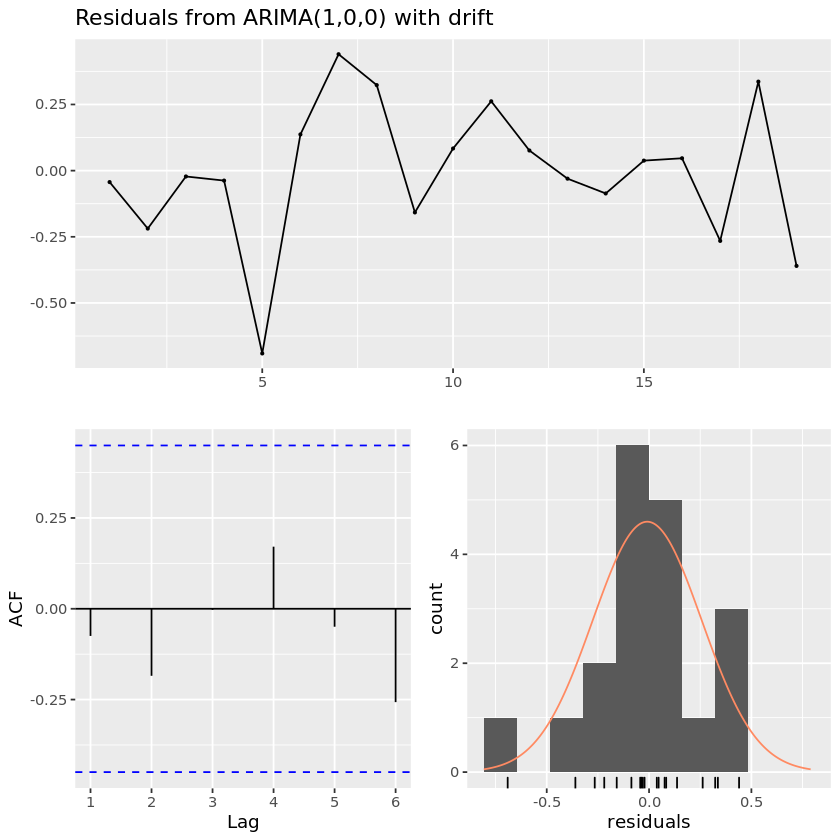

In [12]:
checkresiduals(mdl1)

## Plotting the correct trend

In [13]:
wese<-master_gr$growth_wese
names(wese)<-master_gr$year

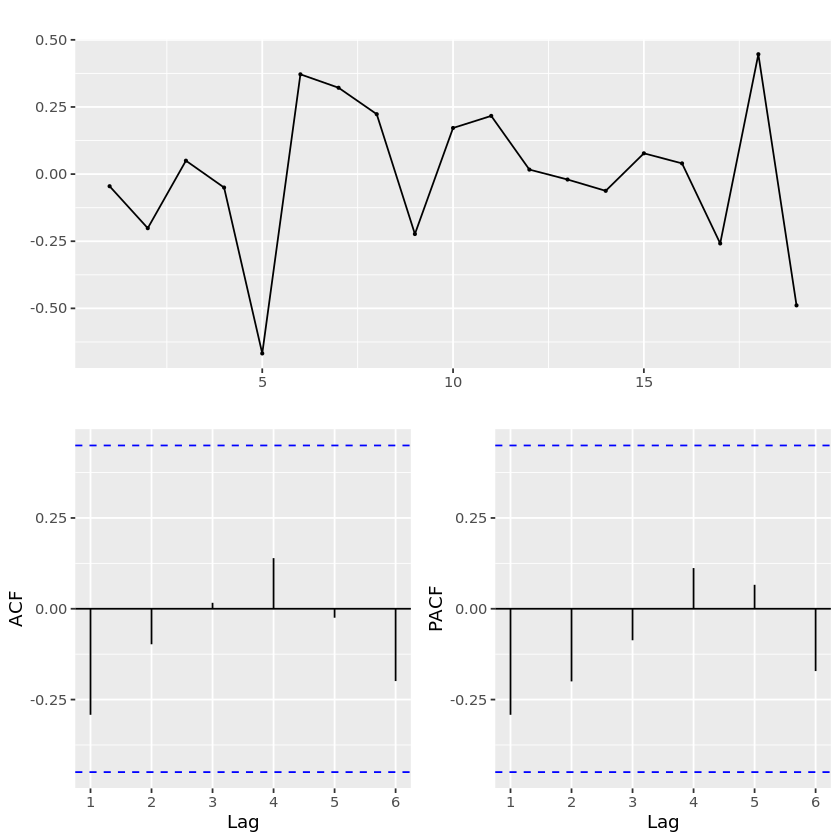

In [14]:
# Uncorrected trend
ggtsdisplay(wese)

In [68]:
#threshold at 10 (it’s equivalent to explaining 99% of the information in a variable by the set of the other covariates).

#select covariates based on variance inflation

in_frame <- master_gr %>% select (FIE, mnWind, nmSST_aw_MCM, Fish_cum3, mnAirTemp, mnOW_MCM6)

vif_func<-function(in_frame,thresh=10,trace=T,...){
  
  
  
  if(class(in_frame) != 'data.frame') in_frame<-data.frame(in_frame)
  
  
  
  #get initial vif value for all comparisons of variables
  
  vif_init<-NULL
  
  var_names <- names(in_frame)
  
  for(val in var_names){
    
    regressors <- var_names[-which(var_names == val)]
    
    form <- paste(regressors, collapse = '+')
    
    form_in <- formula(paste(val, '~', form))
    
    vif_init<-rbind(vif_init, c(val, VIF(lm(form_in, data = in_frame, ...))))
    
  }
  
  vif_max<-max(as.numeric(vif_init[,2]), na.rm = TRUE)
  
  
  
  if(vif_max < thresh){
    
    if(trace==T){ #print output of each iteration
      
      prmatrix(vif_init,collab=c('var','vif'),rowlab=rep('',nrow(vif_init)),quote=F)
      
      cat('\n')
      
      cat(paste('All variables have VIF < ', thresh,', max VIF ',round(vif_max,2), sep=''),'\n\n')
      
    }
    
    return(var_names)
    
  }
  
  else{
    
    
    
    in_dat<-in_frame
    
    
    
    #backwards selection of explanatory variables, stops when all VIF values are below 'thresh'
    
    while(vif_max >= thresh){
      
      
      
      vif_vals<-NULL
      
      var_names <- names(in_dat)
      
      
      
      for(val in var_names){
        
        regressors <- var_names[-which(var_names == val)]
        
        form <- paste(regressors, collapse = '+')
        
        form_in <- formula(paste(val, '~', form))
        
        vif_add<-VIF(lm(form_in, data = in_dat, ...))
        
        vif_vals<-rbind(vif_vals,c(val,vif_add))
        
      }
      
      max_row<-which(vif_vals[,2] == max(as.numeric(vif_vals[,2]), na.rm = TRUE))[1]
      
      
      
      vif_max<-as.numeric(vif_vals[max_row,2])
      
      
      
      if(vif_max<thresh) break
      
      
      
      if(trace==T){ #print output of each iteration
        
        prmatrix(vif_vals,collab=c('var','vif'),rowlab=rep('',nrow(vif_vals)),quote=F)
        
        cat('\n')
        
        cat('removed: ',vif_vals[max_row,1],vif_max,'\n\n')
        
        flush.console()
        
      }
      
      
      
      in_dat<-in_dat[,!names(in_dat) %in% vif_vals[max_row,1]]
      
      
      
    }
    
    
    
    return(names(in_dat))
    
    
    
  }
  
  
  
}
  
vif_func(in_frame,thresh=10,trace=T)

 var          vif             
 FIE          1.18297266177155
 mnWind       1.74451079304158
 nmSST_aw_MCM 3.22846521320152
 Fish_cum3    1.32850220742851
 mnAirTemp    1.16268934156961
 mnOW_MCM6    4.43226845323991

All variables have VIF < 10, max VIF 4.43 



[1] "FIE"          "mnWind"       "nmSST_aw_MCM" "Fish_cum3"    "mnAirTemp"   
[6] "mnOW_MCM6"

# Fish variables

# Fish_cum3= cumulative 3 years (no weights)
# Fish_cum_8_9_1= 3 years with weights (80%, 90% and 100%)
# Fish_cum_6_8_1= 3 years with weights (60%, 80% and 100%)
# Fish_cum2= cumulative 2 years (no weights)
# Fish_cum_75_1= 2 years with weights (75% and 100%)
# Fish_cum_5_1= 2 years with weights (50% and 100%)
# Fish_cum_2_1= 2 years with weights (20% and 100%)

In [48]:
#Saturated model

model_wese<- lm(growth_wese~ FIE+ mnWind + nmSST_aw_MCM + Fish_cum3 + mnAirTemp +  mnOW_MCM6, data=master_gr)

In [49]:
summary(model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + nmSST_aw_MCM + Fish_cum3 + 
    mnAirTemp + mnOW_MCM6, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18676 -0.14400  0.02171  0.11538  0.18245 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.270225   0.682084  -0.396 0.698930    
FIE           0.012968   0.002774   4.675 0.000537 ***
mnWind       -0.088237   0.056801  -1.553 0.146279    
nmSST_aw_MCM  0.136288   0.392480   0.347 0.734420    
Fish_cum3     0.007883   0.004175   1.888 0.083404 .  
mnAirTemp    -0.056598   0.059716  -0.948 0.361937    
mnOW_MCM6     0.100490   0.067869   1.481 0.164475    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1647 on 12 degrees of freedom
Multiple R-squared:  0.772,	Adjusted R-squared:  0.658 
F-statistic: 6.772 on 6 and 12 DF,  p-value: 0.002549


[1] "AIC: -7.34672951128174"

In [19]:
master_gr[,c("year","FIE", "GyreSPD", "mnWind", "nmSST_aw_MCM" ,"Fish_cum3", "Fish_cum_6_8_1", "Fish_cum_75_1", "mnAirTemp", "mnOW_MCM6")]

year,FIE,GyreSPD,mnWind,nmSST_aw_MCM,Fish_cum3,Fish_cum_6_8_1,Fish_cum_75_1,mnAirTemp,mnOW_MCM6
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000,37.2,6.4,7.8,-1.109230,3.259784,3.061944,2.942784,-4.450,2.95968
2001,15.0,6.6,8.6,-0.911519,3.802572,3.036415,2.489676,-6.175,4.36666
2002,44.9,4.4,8.8,-1.109550,4.815376,3.714945,2.234845,-6.050,1.74801
2003,52.0,7.0,8.6,-1.177640,10.204777,9.587261,9.091788,-4.625,2.70145
2004,14.9,7.2,8.4,-1.394120,16.748619,14.499460,13.075569,-5.000,1.11563
2005,47.0,7.8,8.8,-1.099050,27.775821,23.210861,18.169929,-5.250,3.63016
2006,47.0,5.4,8.8,-0.954533,32.132241,26.691748,21.718609,-6.000,4.71894
2007,23.0,4.9,9.4,-1.064650,36.892213,29.360890,21.102856,-6.800,3.90353
2008,20.0,7.4,8.2,-1.173800,33.316336,26.056814,18.164030,-5.025,1.96825


In [20]:
step(model_wese)

Start:  AIC=-63.27
growth_wese ~ FIE + mnWind + nmSST_aw_MCM + Fish_cum3 + mnAirTemp + 
    mnOW_MCM6

               Df Sum of Sq     RSS     AIC
- nmSST_aw_MCM  1   0.00327 0.32883 -65.076
- mnAirTemp     1   0.02437 0.34993 -63.895
<none>                      0.32556 -63.266
- mnOW_MCM6     1   0.05948 0.38503 -62.078
- mnWind        1   0.06547 0.39103 -61.785
- Fish_cum3     1   0.09673 0.42229 -60.324
- FIE           1   0.59298 0.91854 -45.559

Step:  AIC=-65.08
growth_wese ~ FIE + mnWind + Fish_cum3 + mnAirTemp + mnOW_MCM6

            Df Sum of Sq     RSS     AIC
- mnAirTemp  1   0.03622 0.36505 -65.091
<none>                   0.32883 -65.076
- mnWind     1   0.09430 0.42313 -62.286
- Fish_cum3  1   0.09559 0.42442 -62.228
- mnOW_MCM6  1   0.23134 0.56017 -56.955
- FIE        1   0.63340 0.96223 -46.676

Step:  AIC=-65.09
growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6

            Df Sum of Sq     RSS     AIC
<none>                   0.36505 -65.091
- mnWind     1   0.089


Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6, 
    data = master_gr)

Coefficients:
(Intercept)          FIE       mnWind    Fish_cum3    mnOW_MCM6  
  -0.106222     0.012525    -0.094036     0.007306     0.120295  


In [28]:
#trying model above
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6, 
    data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21490 -0.12649 -0.02738  0.12443  0.18778 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.106222   0.424401  -0.250 0.806001    
FIE          0.012525   0.002564   4.884 0.000241 ***
mnWind      -0.094036   0.050653  -1.856 0.084551 .  
Fish_cum3    0.007306   0.003871   1.888 0.079995 .  
mnOW_MCM6    0.120295   0.040046   3.004 0.009478 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1615 on 14 degrees of freedom
Multiple R-squared:  0.7444,	Adjusted R-squared:  0.6713 
F-statistic: 10.19 on 4 and 14 DF,  p-value: 0.0004432


[1] "AIC: -9.17144262858744"

In [29]:
# Including Gyre
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + 
    GyreSPD, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24204 -0.09252  0.04055  0.10300  0.14479 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.045566   0.612832  -1.706 0.113708    
FIE          0.011479   0.002357   4.870 0.000385 ***
mnWind       0.029871   0.070890   0.421 0.680939    
Fish_cum3    0.006597   0.003504   1.883 0.084168 .  
mnOW_MCM6    0.101887   0.037035   2.751 0.017567 *  
GyreSPD     -0.003657   0.034611  -0.106 0.917609    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1456 on 12 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.7845,	Adjusted R-squared:  0.6947 
F-statistic: 8.738 on 5 and 12 DF,  p-value: 0.001081


[1] "AIC: -11.5915917537371"

In [50]:
#trying ALL FISH_CUM. BEST MODEL?  Best model is with Fish_cum3
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + 
    GyreSPD, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24204 -0.09252  0.04055  0.10300  0.14479 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.045566   0.612832  -1.706 0.113708    
FIE          0.011479   0.002357   4.870 0.000385 ***
mnWind       0.029871   0.070890   0.421 0.680939    
Fish_cum3    0.006597   0.003504   1.883 0.084168 .  
mnOW_MCM6    0.101887   0.037035   2.751 0.017567 *  
GyreSPD     -0.003657   0.034611  -0.106 0.917609    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1456 on 12 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.7845,	Adjusted R-squared:  0.6947 
F-statistic: 8.738 on 5 and 12 DF,  p-value: 0.001081


[1] "AIC: -11.5915917537371"

In [47]:
test <- cor.test(master_gr$FIE, master_gr$mnOW_MCM6, method= "spearman")
test


Warning message in cor.test.default(master_gr$FIE, master_gr$mnOW_MCM6, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  master_gr$FIE and master_gr$mnOW_MCM6
S = 1255.5, p-value = 0.6798
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1013226 


# BEST MODEL

In [46]:
#excluding wind - this is the best model by AIC + LRT (by AIC alone justified to include gyre speed)
model_wese<- lm(formula = growth_wese ~ FIE + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + Fish_cum3 + mnOW_MCM6 + GyreSPD, 
    data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.23327 -0.09988  0.01627  0.11335  0.13800 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.813934   0.262161  -3.105 0.008371 ** 
FIE          0.011534   0.002278   5.064 0.000217 ***
Fish_cum3    0.006581   0.003391   1.941 0.074283 .  
mnOW_MCM6    0.109668   0.031071   3.530 0.003698 ** 
GyreSPD     -0.003478   0.033496  -0.104 0.918890    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1409 on 13 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.7813,	Adjusted R-squared:  0.714 
F-statistic: 11.61 on 4 and 13 DF,  p-value: 0.0003108


[1] "AIC: -13.3272218352494"

In [67]:
model_wese<- lm(formula = growth_wese ~ 1, data = master_gr)
summary (model_wese) 
paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ 1, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66355 -0.12752  0.02109  0.19861  0.45072 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.004283   0.064617  -0.066    0.948

Residual standard error: 0.2817 on 18 degrees of freedom


[1] "AIC: 8.74395895850825"

In [52]:
#excluding wind - this is the best model by AIC + LRT (by AIC alone justified to include gyre speed)
model_wese<- lm(formula = growth_wese ~ FIE + Fish_cum3 + mnOW_MCM6 , data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + Fish_cum3 + mnOW_MCM6, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40010 -0.09059  0.05752  0.10197  0.19379 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.841202   0.164904  -5.101 0.000130 ***
FIE          0.013224   0.002736   4.834 0.000219 ***
Fish_cum3    0.008185   0.004143   1.976 0.066905 .  
mnOW_MCM6    0.080802   0.036591   2.208 0.043211 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1741 on 15 degrees of freedom
Multiple R-squared:  0.6814,	Adjusted R-squared:  0.6177 
F-statistic: 10.69 on 3 and 15 DF,  p-value: 0.0005166


[1] "AIC: -6.98985208382591"

In [40]:
## Checking Likelihood ratio tests to see if excluding wind is justified
library(lmtest)
model_wese_wind<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
model_wese<-lm(formula = growth_wese ~ FIE + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
lrtest(model_wese_wind,model_wese)

# We cannot do the same for Gyre speed because the model without it uses 2019 data 
# so has one more record than the model with gyre speed

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,12.79580,NA,NA,NA
2,6,12.66361,-1,0.2643699,0.6071337


### By the LRTest above we are justified in not including Wind

In [55]:
model_wese<- lm(formula = growth_wese ~ 1, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ 1, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66355 -0.12752  0.02109  0.19861  0.45072 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.004283   0.064617  -0.066    0.948

Residual standard error: 0.2817 on 18 degrees of freedom


[1] "AIC: 8.74395895850825"

In [42]:
save(master_gr,model_wese,file="/home/ubuntu/Workspace/Anthropocene/data/bestWESEmodel.RData")